In [1]:
import pathlib as pl
from PIL import Image
import datasets
from datasets import Dataset
from datasets import Image as DSImage
import numpy as np
import cv2
import matplotlib.pyplot as plt
# files = list((pl.Path(__file__).parent / "inference_inputs").glob("*"))
files = list((pl.Path(".").parent / "inference_inputs").glob("*"))
print(files)
# exit()


/home/users/aashrayc/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[PosixPath('inference_inputs/36_0009200_0009224-reel_begin_end.tiff')]


/home/users/aashrayc/.local/lib/python3.12/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (91173600 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


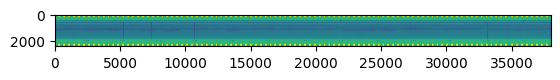

In [2]:
plt.imshow(Image.open(files[0]))

In [3]:

def window_with_remainder(length, overlap, input_size):
    testarray = np.arange(0, input_size)
    return np.vstack(
        (
            testarray[0:length],
            np.lib.stride_tricks.sliding_window_view(
                testarray[len(testarray) % length :], length
            )[::overlap],
        )
    )[:, [0, -1]] + [0, 1]
# Converts an image from cv2 to PIL
def convert_from_cv2_to_image(img: np.ndarray) -> Image:
    # return Image.fromarray(img)
    return Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# Converts an image from PIL to cv2
def convert_from_image_to_cv2(img: Image) -> np.ndarray:
    # return np.asarray(img)
    return cv2.cvtColor(src=np.array(img, dtype=np.uint8), code=cv2.COLOR_RGB2BGR)
# Splits an longer image into a series of smaller images with a given overlap
# to reduce memory costs it takes in the length, input size and returns a list of valid indices
def window_with_remainder(length, overlap, input_size):
    testarray = np.arange(0, input_size)
    return np.vstack(
        (
            testarray[0:length],
            np.lib.stride_tricks.sliding_window_view(
                testarray[len(testarray) % length :], length
            )[::overlap],
        )
    )[:, [0, -1]] + [0, 1]
# does canny edge detection on an image


In [5]:
# def canny_image(image: Image):
#     # Read the image

#     # Convert the image to grayscale
#     gray = cv2.cvtColor(convert_from_image_to_cv2(image), cv2.COLOR_BGR2GRAY)

#     mean_power = np.mean(gray) / 255
#     print(f"Mean power of the grayscale image: {mean_power}")
#     std = np.std(gray) / 255
#     print(f"Variance of the grayscale image: {std}")

#     t1 = ((mean_power - (2 * std)) * 255, (mean_power - (1 * std)) * 255)
#     t2 = ((mean_power + (1 * std)) * 255, (mean_power + (2 * std)) * 255)
#     t3 = ((mean_power - (1 * std)) * 255, (mean_power + (1 * std)) * 255)

#     # Perform Canny edge detection on the grayscale image with two different thresholds
#     edges1 = cv2.Canny(gray, threshold1=t1[0], threshold2=t1[1])
#     edges2 = cv2.Canny(
#         cv2.GaussianBlur(gray, (11, 11), std * 4, std / 2),
#         threshold1=t2[0],
#         threshold2=t2[1],
#     )
#     edges3 = cv2.Canny(gray, threshold1=t3[0], threshold2=t3[1])

#     kernel = np.ones((10, 10), np.uint8)
#     edges3 = cv2.dilate(edges3, kernel, iterations=1)

#     combined_image = np.zeros((gray.shape[0], gray.shape[1], 3), dtype=np.uint8)
#     edges1 = cv2.Canny(gray, threshold1=t1[0], threshold2=t1[1])
#     edges2 = cv2.Canny(
#         cv2.GaussianBlur(gray, (11, 11), std * 4, std / 2),
#         threshold1=t2[0],
#         threshold2=t2[1],
#     )
#     edges3 = cv2.Canny(gray, threshold1=t3[0], threshold2=t3[1])

#     kernel = np.ones((10, 10), np.uint8)
#     edges3 = cv2.dilate(edges3, kernel, iterations=1)

#     combined_image = np.zeros((gray.shape[0], gray.shape[1], 3), dtype=np.uint8)

#     combined_image[:, :, 0] = gray

#     combined_image[:, :, 1] = edges1 + edges3 * 0.3
#     combined_image[:, :, 0] = gray

#     combined_image[:, :, 1] = edges1 + edges3 * 0.3

#     # Set the third color channel as edges2
#     combined_image[:, :, 2] = edges2 + edges3 * 0.3
#     combined_image[:, :, 2] = edges2 + edges3 * 0.3

#     return convert_from_cv2_to_image(combined_image)

In [36]:
def canny_image(image: Image):
    # Read the image

    # Convert the image to grayscale
    gray = cv2.cvtColor(convert_from_image_to_cv2(image), cv2.COLOR_BGR2GRAY)

    combined_image = np.zeros((gray.shape[0], gray.shape[1], 3), dtype=np.uint8)
    
    blurred = cv2.GaussianBlur(gray,(15,15),0)
    # blurred=gray

    green = cv2.convertScaleAbs(cv2.Laplacian(blurred,cv2.CV_32F,7))
    blue = cv2.convertScaleAbs(cv2.Scharr(blurred,cv2.CV_32F,0,1))
    
    combined_image[:,:,0] = gray
    combined_image[:,:,1] = np.clip(np.round(green+gray),0,255)
    combined_image[:,:,2] = np.clip(np.round(blue*.5+gray*.5),0,255)
   
    
    return convert_from_cv2_to_image(combined_image)

In [37]:
image_paths = []
for c, i in enumerate(files):
    img = Image.open(i)
    img = img.crop((0, 430, img.size[0], 1790))
    img = Image.fromarray(np.array(img) / 255)
    img = img.convert("L")
    cropping_coordinates = window_with_remainder(512, 128, img.size[0])
    file_path = pl.Path("./inference_raw_imgs") / i.stem
    file_path.mkdir(exist_ok=True)
    for count, (start, end) in enumerate(cropping_coordinates):
        save_path = file_path / f"{count}-{start}-{end}.png"
        cimg = img.crop((start, 0, end, img.size[1])).resize((512, 512))
        resized = canny_image(cimg)
        resized.save(save_path)    
        print(f"finished {save_path}")
        image_paths.append(str(save_path.resolve()))
        # break
    print("\n--\n")

dataset = Dataset.from_dict({"image": sorted(image_paths)})
dataset = dataset.cast_column("image", DSImage())
# prints dataset information
print(dataset)
print(dataset.info)
print(dataset.features)
dataset.save_to_disk("./inference_dataset/inference_dataset.hf")



/home/users/aashrayc/.local/lib/python3.12/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (91173600 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


finished inference_raw_imgs/36_0009200_0009224-reel_begin_end/0-0-512.png
finished inference_raw_imgs/36_0009200_0009224-reel_begin_end/1-101-613.png
finished inference_raw_imgs/36_0009200_0009224-reel_begin_end/2-229-741.png
finished inference_raw_imgs/36_0009200_0009224-reel_begin_end/3-357-869.png
finished inference_raw_imgs/36_0009200_0009224-reel_begin_end/4-485-997.png
finished inference_raw_imgs/36_0009200_0009224-reel_begin_end/5-613-1125.png
finished inference_raw_imgs/36_0009200_0009224-reel_begin_end/6-741-1253.png
finished inference_raw_imgs/36_0009200_0009224-reel_begin_end/7-869-1381.png
finished inference_raw_imgs/36_0009200_0009224-reel_begin_end/8-997-1509.png
finished inference_raw_imgs/36_0009200_0009224-reel_begin_end/9-1125-1637.png
finished inference_raw_imgs/36_0009200_0009224-reel_begin_end/10-1253-1765.png
finished inference_raw_imgs/36_0009200_0009224-reel_begin_end/11-1381-1893.png
finished inference_raw_imgs/36_0009200_0009224-reel_begin_end/12-1509-2021.png

Saving the dataset (1/1 shards): 100%|██████████| 294/294 [00:01<00:00, 209.24 examples/s]


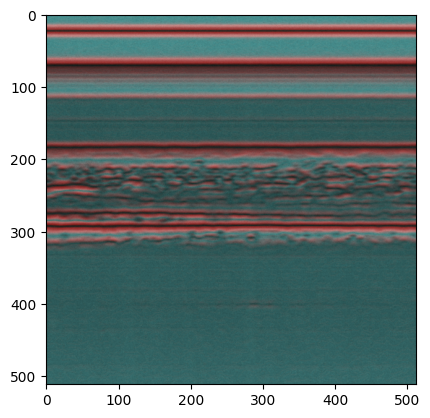

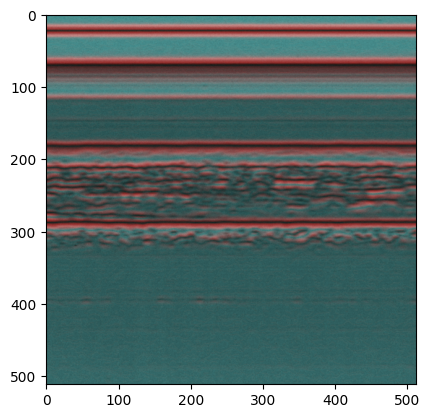

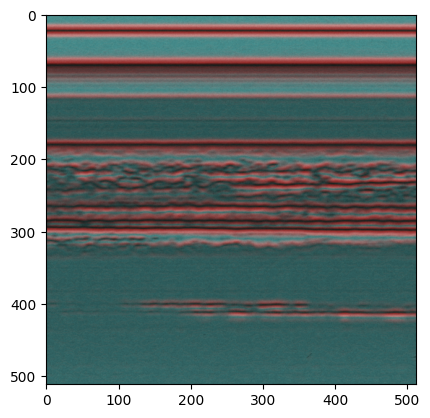

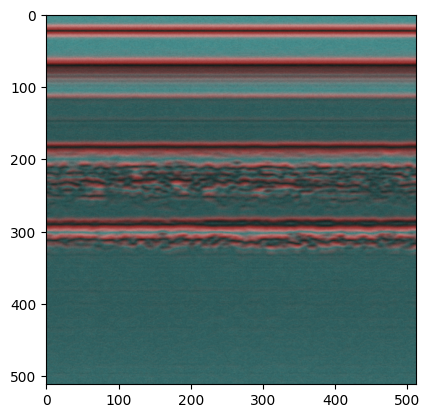

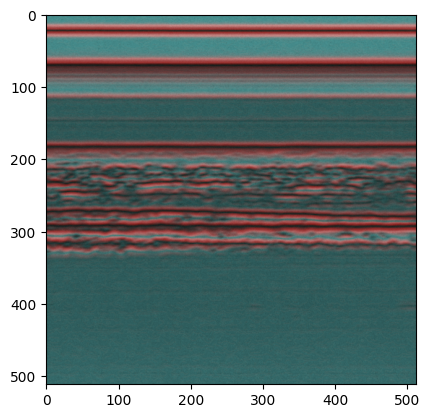

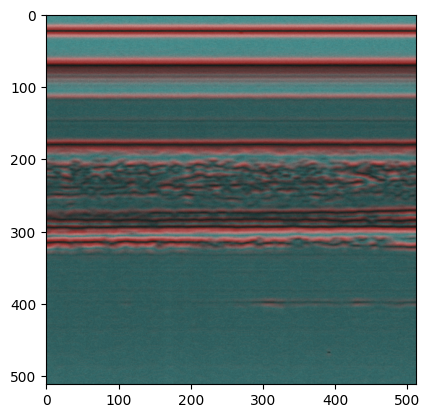

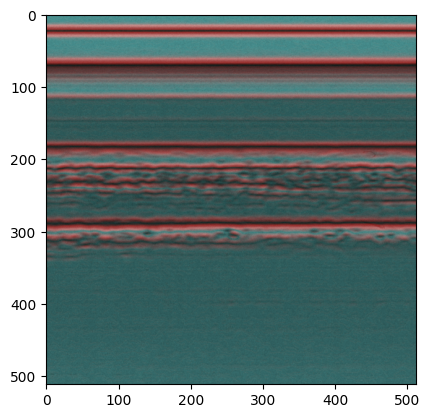

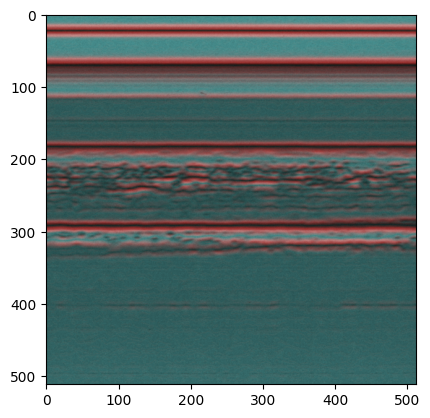

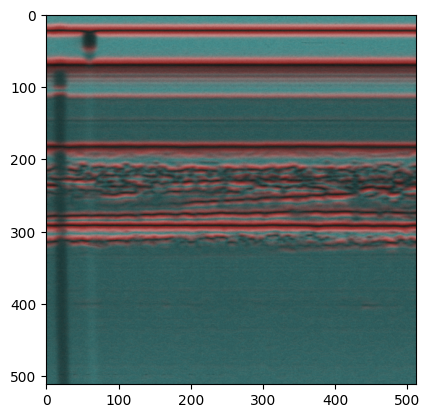

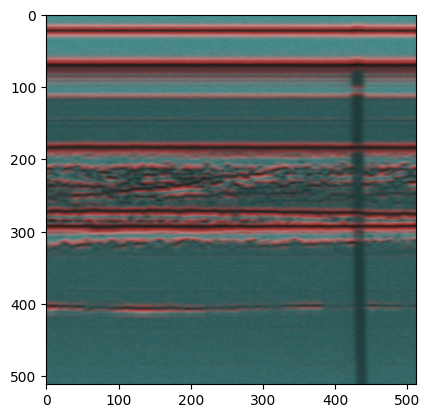

In [38]:
import random
for i in dataset.select(random.sample(list(range(len(dataset))),10)):
    plt.imshow(i["image"])
    plt.show()